# Selection of lakes
***

**Author:** Chus Casado Rodríguez<br>
**Date:** 26-07-2023<br>

**Introduction:**<br>


**To do:**
* [ ] Filter the `glwd_new` table to reduce the amount of lakes to add in GloFAS.
* [ ] Do the previous filter by volume, similarly to the reservoirs.
* [ ] Is it of any interest to analyse HydroATLAS? <format font='steelblue'>Yes, since it's the only data set that includes volume.</format>


In [1]:
import os
os.environ['USE_PYGEOS'] = '0'
import glob
import pandas as pd
import dask.dataframe as dd
import dask_geopandas as dgpd
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import geopandas as gpd
import cartopy.feature as cfeature
import cartopy.crs as ccrs
from tqdm.notebook import tqdm
from shapely.geometry import Point

In [2]:
# paths
path_datasets = 'E:/casadje/jrcbox/datasets/'
path_out = '../results/lakes/selection/'
if os.path.exists(path_out) is False:
    os.makedirs(path_out)

## GloFAS

In [3]:
# minimum lake surface area included in GloFAS
min_area = 50 # km2

# spatial resolution in GloFAS v4
glofas_pixel = .05 # degrees

# path where the GloFAS data is stored
path_GloFAS = '../data/lakes_wetlands/GloFAS/'

#### Raster

In [4]:
glofas_raster = xr.open_dataset(f'{path_GloFAS}20220802_lakes_Global_03min.nc')['lakes']

# remove rows/columns with all NaN
aux = glofas_raster.where(~glofas_raster.isnull(), drop=True)
# extract an array of reservoir ID
ids = np.unique(aux)
ids = ids[~np.isnan(ids)]

# extract coordinates of each reservoir
glofas_coords = pd.DataFrame(index=ids, columns=['lon', 'lat'])
for id in tqdm(glofas_coords.index):
    cell = glofas_raster.where(glofas_raster == id, drop=True)
    glofas_coords.loc[id] = cell.lon.data[0], cell.lat.data[0]
glofas_coords = glofas_coords.round(3)

del aux

  0%|          | 0/464 [00:00<?, ?it/s]

#### Metadata

In [5]:
glofas = pd.read_csv(f'{path_GloFAS}GLOFAS_HRES_lakes_metadata.csv')
glofas.set_index('LakID', inplace=True)

# add attributes from the tables used in LISFLOOD
for file in glob.glob(f'{path_GloFAS}*.txt'):
    var = file.split('\\')[-1].split('_')[0][4:]
    try:
        df = pd.read_csv(file, sep='\t', header=None)
        df.dropna(axis=1, how='all', inplace=True)
        df.columns = ['LakID', var]
        df.set_index('LakID', inplace=True, drop=True)
        glofas[var] = df
    except:
        print(file)
        continue
glofas['A'] = glofas.area / 1e6 # convert area to km2
glofas.drop('area', axis=1, inplace=True)

#### Comparison

In [6]:
print('no. lakes in the metadata:\t{0}'.format(glofas.shape[0]))
print('no. lakes in the raster:\t{0}'.format(glofas_coords.shape[0]))
print('lakes missing in the metadata:\t{0}'.format(glofas_coords.index.difference(glofas.index).to_list()))
print('lakes missing in the raster:\t{0}'.format(glofas.index.difference(glofas_coords.index).to_list()))

no. lakes in the metadata:	463
no. lakes in the raster:	464
lakes missing in the metadata:	[-9999.0]
lakes missing in the raster:	[]


In [7]:
# remove one of the instances of the Therthar lake
glofas_coords.drop(-9999, axis=0, inplace=True)

In [8]:
# create geopandas.GeoDataFrame
glofas = gpd.GeoDataFrame(glofas, geometry=[Point(xy) for xy in zip(glofas.LisfloodX3, glofas.LisfloodY3)])
glofas.crs = 'EPSG:4326'

no. lakes in GloFAS:		463
total lake area in GloFAS:	755377 km²
no. lakes (A > 50 km²):		463


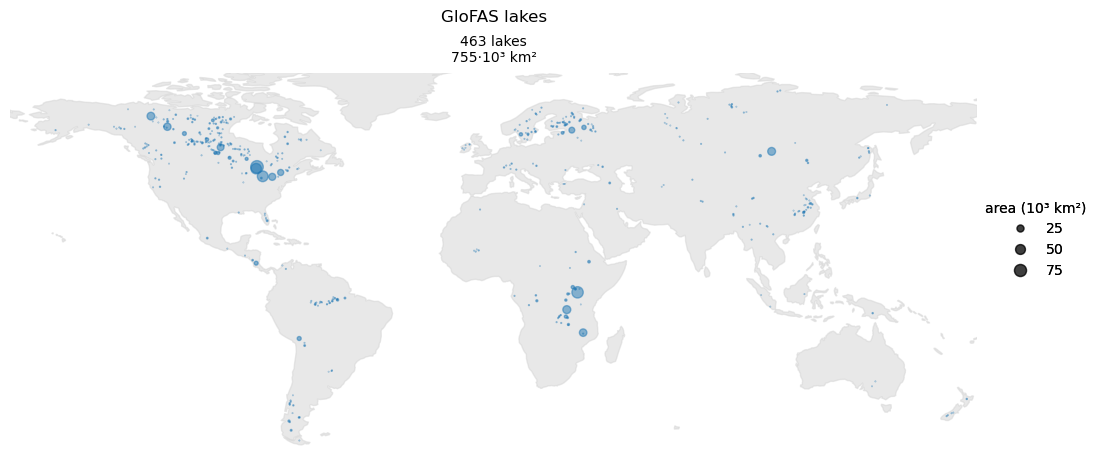

In [9]:
# map of GloFAS lakes
fig, ax = plt.subplots(figsize=(20, 5), subplot_kw=dict(projection=ccrs.PlateCarree()))
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '110m', edgecolor='face', facecolor='lightgray'), alpha=.5, zorder=0)
# glofas.plot(markersize=glofas.A * .5e-2, alpha=.5, ax=ax)#, cmap='coolwarm', c=grand_dams.DOR_PC
scatter = ax.scatter(glofas.geometry.x, glofas.geometry.y, s=glofas.A / 1000, alpha=.5)
ax.text(.5, 1.125, 'GloFAS lakes', horizontalalignment='center', verticalalignment='bottom', transform=ax.transAxes, fontsize=12)
text = '{0} lakes\n{1:.0f}·10³ km²'.format(glofas.shape[0], glofas.A.sum() / 1000)
ax.text(.5, 1.02, text, horizontalalignment='center', verticalalignment='bottom', transform=ax.transAxes)
ax.axis('off');

# legend
legend2 = ax.legend(*scatter.legend_elements(prop='sizes', num=4, alpha=.5), title='area (10³ km²)', bbox_to_anchor=[1.025, .3, .1, .4], frameon=False)
ax.add_artist(legend2);

# save
plt.savefig(f'{path_out}glofas_lakes.jpg', dpi=300, bbox_inches='tight')

print('no. lakes in GloFAS:\t\t{0}'.format(glofas.shape[0]))
print('total lake area in GloFAS:\t{0:.0f} km²'.format(glofas.A.sum()))
print('no. lakes (A > {0} km²):\t\t{1}'.format(min_area, (glofas.A >= min_area).sum()))

***Figure 1**. Lakes included in GloFAS. The size of the dots represents the lake area.*

Area of the smallest lake:	50.000 km²


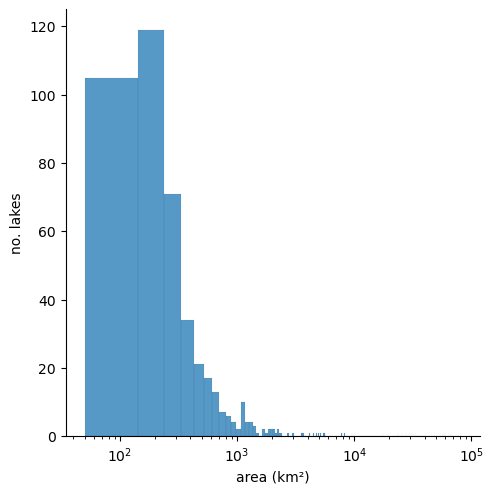

In [10]:
# distribution of the lake area
sns.displot(glofas.A)
plt.xlabel('area (km²)')
plt.ylabel('no. lakes');
plt.xscale('log');

print('Area of the smallest lake:\t{0:.3f} km²'.format(glofas.A.min()))

As explained in Zajac et al. (2017), only lakes with a minimum area of 50 km² are included in GloFAS.

## Global Lakes and Wetlands Database (GLWD)

GLWD is the only source of information about lakes currently included in GloFAS. GLWD includes polygons of the water bodies (either lakes or reservoirs); I will keep only lakes here. It also defines whether a lake is open or closed; I will keep only open lakes, since those are the ones affecting the hydrological simulation downstream the lake.

Field `TYPE`:
* _Lake_
* _Reservoir_

Field `MGLD_TYPE`:
* _open_: lake with significant surface or subsurface outflow.
* _closed_: lake without significant surface or subsurface outflow (inland sink).
* _closedx_: lake probably without significant surface or subsurface outflow (inland sink).
* _res_: reservoir.

I will filter by these 2 fields to keep only open lakes.

In [11]:
# import data set
path_glwd = f'{path_datasets}lakes/GLWD/level1/'
glwd = gpd.read_file(f'{path_glwd}glwd_1.shp')
glwd.set_index('GLWD_ID', drop=True, inplace=True)
glwd.crs = 'EPSG:4326'

# keep only open lakes
glwd = glwd.loc[(glwd.TYPE == 'Lake') & (glwd.MGLD_TYPE == 'open')]

# recompute catchment area in km²
glwd['CATCH_SKM'] = glwd.CATCH_TSKM * 1000
glwd.drop('CATCH_TSKM', axis=1, inplace=True)

# compute a mm equivalent inflow as the quotient beteween inflow volume and lake area
glwd['INFLOW_MM'] = glwd.INFLOW_CMS / glwd.AREA_SKM * 3600 * 24 * 365 * 1e-6 

# fill in attributes of Lake Victoria
glofas.loc[glofas.GLWD_ID.isnull(), ['GLWD_ID', 'CONTINENT']] = [3, 'Africa']
cols = ['COUNTRY', 'LONG_DEG', 'LAT_DEG']
glofas.loc[glofas.GLWD_ID.isnull(), cols] = glwd.loc[3, cols]

# add a boolean field whether the lake is already included in GloFAS or not
glwd['GloFAS'] = glwd.index.isin(glofas.GLWD_ID)

# remove empty fields
glwd.dropna(axis=1, how='all', inplace=True)

# convert polygon GeoDataFrame to point GeoDataFrame
glwd = gpd.GeoDataFrame(glwd, geometry=[Point(xy) for xy in zip(glwd.LONG_DEG, glwd.LAT_DEG)])
glwd .crs = 'EPSG:4326'

# # tune lake names in GLWD
# glwd.LAKE_NAME = glwd.LAKE_NAME.str.lower()
# glwd.LAKE_NAME = glwd.LAKE_NAME.str.replace(r'(lake|reservoir)', '', case=False)
# glwd.LAKE_NAME = glwd.LAKE_NAME.str.strip()

no. lakes in GLWD:		768
total lake area in GLWD:	850790 km²
no. lakes (A > 50 km²):		766


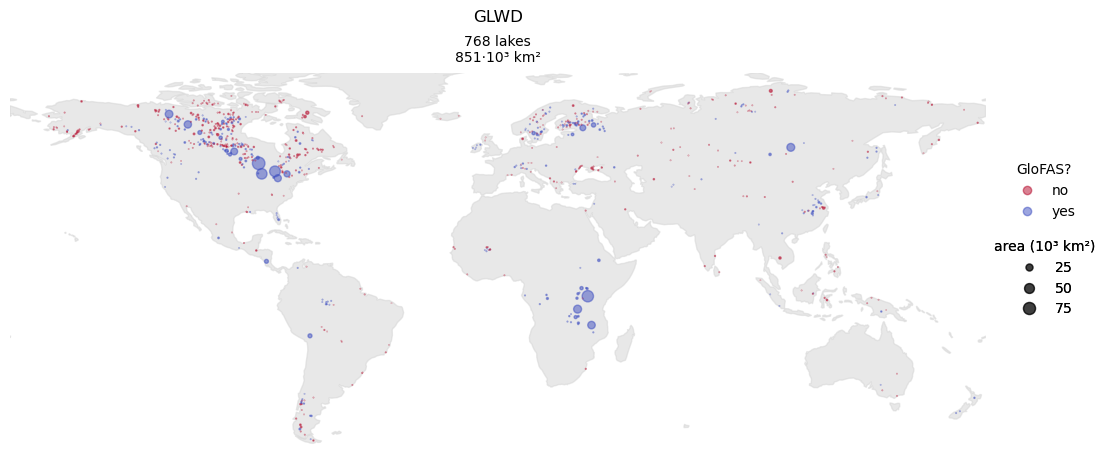

In [12]:
fig, ax = plt.subplots(figsize=(20, 5), subplot_kw=dict(projection=ccrs.PlateCarree()))
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '110m', edgecolor='face', facecolor='lightgray'), alpha=.5, zorder=0)
scatter = ax.scatter(glwd.geometry.x, glwd.geometry.y, s=glwd.AREA_SKM / 1000, cmap='coolwarm_r', c=glwd.GloFAS, alpha=.5)
ax.text(.5, 1.125, 'GLWD', horizontalalignment='center', verticalalignment='bottom', transform=ax.transAxes, fontsize=12)
text = '{0} lakes\n{1:.0f}·10³ km²'.format(glwd.shape[0], glwd.AREA_SKM.sum() / 1000)
ax.text(.5, 1.02, text, horizontalalignment='center', verticalalignment='bottom', transform=ax.transAxes)
ax.axis('off');

# legend
handles1, labels1 = scatter.legend_elements(prop='colors', alpha=0.5)
labels1 = ['no', 'yes']
legend1 = ax.legend(handles1, labels1, title='GloFAS?', bbox_to_anchor=[1.005, .55, .1, .25], frameon=False)
ax.add_artist(legend1)
legend2 = ax.legend(*scatter.legend_elements(prop='sizes', num=4, alpha=.5), title='area (10³ km²)', bbox_to_anchor=[1.025, .35, .1, .25], frameon=False)
ax.add_artist(legend2);

plt.savefig(f'{path_out}glwd_lakes.jpg', dpi=300, bbox_inches='tight')

print('no. lakes in GLWD:\t\t{0}'.format(glwd.shape[0]))
print('total lake area in GLWD:\t{0:.0f} km²'.format(glwd.AREA_SKM.sum()))
print('no. lakes (A > {0} km²):\t\t{1}'.format(min_area, (glwd.AREA_SKM >= min_area).sum()))

***Figure 3**. Lakes in the GLWD data set. The dot size indicates the lake area. Blue dots are lakes included in GloFAS, whereas red dots are excluded from GloFAS.*

The GLWD data set includes 768 open lakes, all but 2 with a lake area larger than 50 km². It means that 303 open lakes in GLWD with area larger than 50 km² were filtered out of GloFAS for other reason.

Only 1 lake in GloFAS does not have a `GLWD_ID`. It corresponds to lake Victoria (`GLWD_ID=3`). I will fill in manually its attributes.

In [13]:
missing = glwd.index.difference(glofas.GLWD_ID)
glwd_new = glwd.loc[missing]

In [14]:
# select GWLD reservoirs not included in GloFAS
glwd_mask_area = glwd.AREA_SKM >= min_area
missing = glwd[glwd_mask_area].index.difference(glofas.GLWD_ID)
glwd_new = glwd.loc[missing]

# remove empty fields
glwd_new.dropna(axis=1, how='all', inplace=True)

# # create geopandas.GeoDataFrame
# glwd_new = gpd.GeoDataFrame(glwd_new, geometry=[Point(xy) for xy in zip(glwd_new.LONG_DEG, glwd_new.LAT_DEG)])
# glwd_new.crs = 'EPSG:4326'

In [15]:
def scientific_format(num):
    if num == 0:
        return '0'
    else:
        exponent = int(np.log10(abs(num)))
        prefix = num / 10**(exponent - 1)
        suffix = '⁰¹²³⁴⁵⁶⁷⁸⁹'[exponent]  # Unicode superscript digits for 0 to 9
        return f"{prefix:.0f}{suffix}"

no. lakes:		472
total lake area:	140840 km²


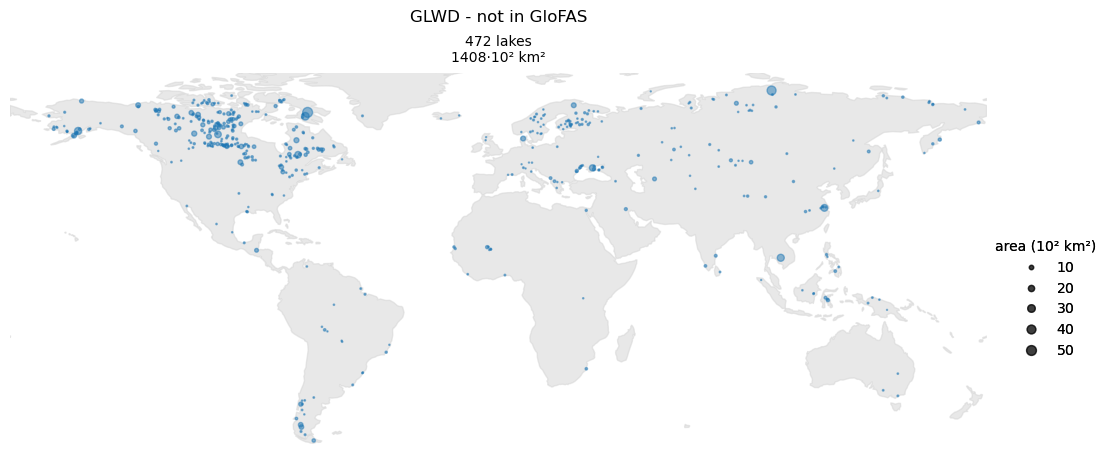

In [16]:
r = 100

fig, ax = plt.subplots(figsize=(20, 5), subplot_kw=dict(projection=ccrs.PlateCarree()))
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '110m', edgecolor='face', facecolor='lightgray'), alpha=.5, zorder=0)
scatter = plt.scatter(glwd_new.geometry.x, glwd_new.geometry.y, s=glwd_new.AREA_SKM / r,
                      alpha=.5) #, cmap='coolwarm', c=np.log10(glwd_new.CATCH_SKM.replace(0, np.nan)))
ax.text(.5, 1.125, 'GLWD - not in GloFAS', horizontalalignment='center', verticalalignment='bottom',
        transform=ax.transAxes, fontsize=12)
text = '{0} lakes\n{1:.0f}·{2} km²'.format(glwd_new.shape[0], glwd_new.AREA_SKM.sum() / r, scientific_format(r))
ax.text(.5, 1.02, text, horizontalalignment='center', verticalalignment='bottom', transform=ax.transAxes)
ax.axis('off');

# legend
# legend1 = ax.legend(*scatter.legend_elements(prop='colors', num=4, alpha=.5), title='log10(catchment) (km²)', bbox_to_anchor=[1.025, .6, .1, .25], frameon=False)
# ax.add_artist(legend1)
legend2 = ax.legend(*scatter.legend_elements(prop='sizes', num=4, alpha=.5), title='area ({0} km²)'.format(scientific_format(r)),
                    bbox_to_anchor=[1.025, .35, .1, .25], frameon=False)
ax.add_artist(legend2);

print('no. lakes:\t\t{0}'.format(glwd_new.shape[0]))
print('total lake area:\t{0:.0f} km²'.format(glwd_new.AREA_SKM.sum()))

**Catchment area**

no. new lakes (A >= 1000 km²):	322
no. new lakes (A >= 2000 km²):	228


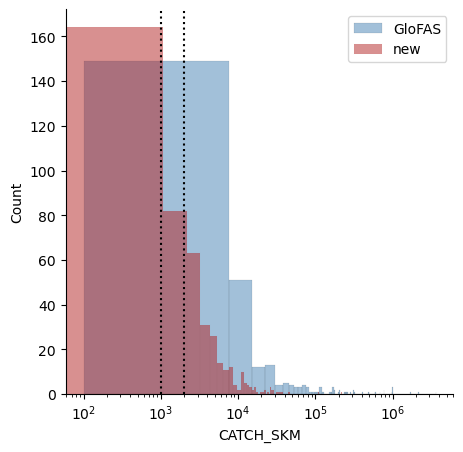

In [17]:
for A in [1000, 2000]:
    print('no. new lakes (A >= {0} km²):\t{1}'.format(A, (glwd_new.CATCH_SKM >= A).sum()))

fig, ax = plt.subplots(figsize=(5, 5))
sns.histplot(glwd[glwd.GloFAS].CATCH_SKM, color='steelblue', alpha=.5, ax=ax, label='GloFAS')
sns.histplot(glwd_new.CATCH_SKM, color='firebrick', alpha=.5, ax=ax, label='new')
for A in [1000, 2000]:
    plt.axvline(A, linestyle=':', color='k')
ax.set_xscale('log')
ax.spines[['top', 'right']].set_visible(False)
ax.legend();

no. lakes:		228
total lake area:	98611 km²


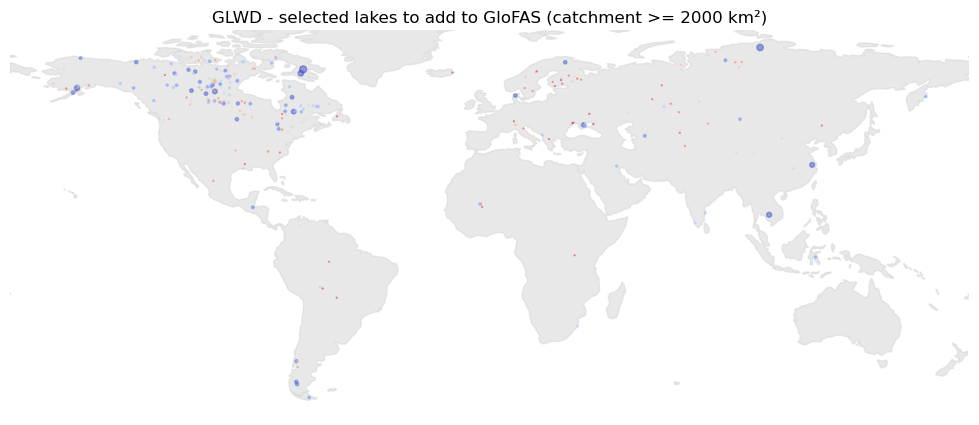

In [18]:
min_catchment = 2000
glwd_mask_catchment = glwd_new.CATCH_SKM >= min_catchment
glwd_new_1 = glwd_new[glwd_mask_catchment]

fig, ax = plt.subplots(figsize=(20, 5), subplot_kw=dict(projection=ccrs.PlateCarree()))
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '110m', edgecolor='face', facecolor='lightgray'), alpha=.5, zorder=0)
glwd_new_1.plot(markersize=glwd_new_1.AREA_SKM * .5e-2, cmap='coolwarm', c=glwd_new_1.INFLOW_MM, alpha=.5, ax=ax, legend=True)#, color='firebrick'
ax.set_title('GLWD - selected lakes to add to GloFAS (catchment >= {0} km²)'.format(min_catchment))
ax.axis('off');

print('no. lakes:\t\t{0}'.format(glwd_new_1.shape[0]))
print('total lake area:\t{0:.0f} km²'.format(glwd_new_1.AREA_SKM.sum()))

**Inflow**

no. new lakes (Q >= 10 m3/s):	209
no. new lakes (Q >= 100 m3/s):	38


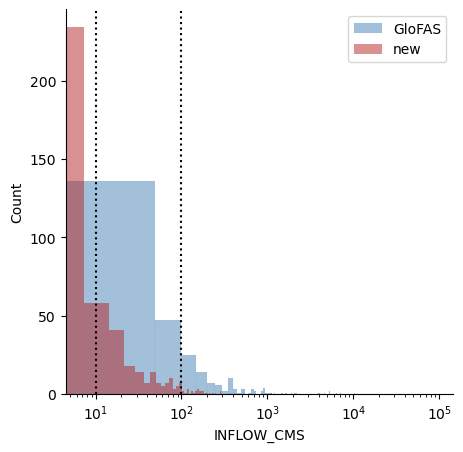

In [19]:
for Q in [10, 100]:
    print('no. new lakes (Q >= {0} m3/s):\t{1}'.format(Q, (glwd_new.INFLOW_CMS >= Q).sum()))

fig, ax = plt.subplots(figsize=(5, 5))
sns.histplot(glwd[glwd.GloFAS].INFLOW_CMS, color='steelblue', alpha=.5, ax=ax, label='GloFAS')
sns.histplot(glwd_new.INFLOW_CMS, color='firebrick', alpha=.5, ax=ax, label='new')
for Q in [10, 100]:
    plt.axvline(Q, linestyle=':', color='k')
ax.set_xscale('log')
ax.spines[['top', 'right']].set_visible(False)
ax.legend();

no. lakes:		209
total lake area:	79970 km²


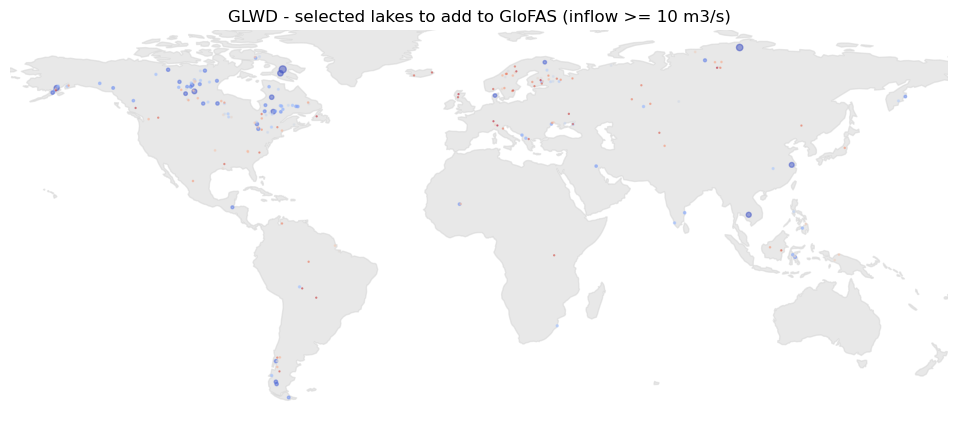

In [20]:
min_inflow = 10
glwd_mask_inflow = glwd_new.INFLOW_CMS >= min_inflow
glwd_new_2 = glwd_new[glwd_mask_inflow]

fig, ax = plt.subplots(figsize=(20, 5), subplot_kw=dict(projection=ccrs.PlateCarree()))
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '110m', edgecolor='face', facecolor='lightgray'), alpha=.5, zorder=0)
glwd_new_2.plot(markersize=glwd_new_1.AREA_SKM * .5e-2, cmap='coolwarm', c=glwd_new_2.INFLOW_MM, alpha=.5, ax=ax, legend=True)#, color='firebrick'
ax.set_title('GLWD - selected lakes to add to GloFAS (inflow >= {0} m3/s)'.format(min_inflow))
ax.axis('off');

print('no. lakes:\t\t{0}'.format(glwd_new_2.shape[0]))
print('total lake area:\t{0:.0f} km²'.format(glwd_new_2.AREA_SKM.sum()))

**Ratio inflow vs lake area**

I will derive a kind of "degree of regulation" as the equivalent mm of inflow per year. To do that, I divide the annual inflow volume by the total area and convert to mm.

no. new lakes (Q <= 1 m3/s):	227
no. new lakes (Q <= 2 m3/s):	283


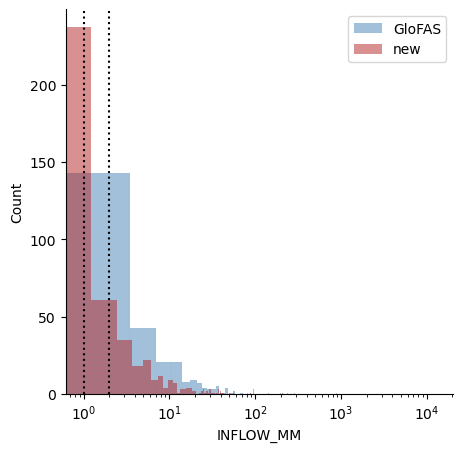

In [21]:
for Q in [1, 2]:
    print('no. new lakes (Q <= {0} m3/s):\t{1}'.format(Q, (glwd_new.INFLOW_MM <= Q).sum()))

fig, ax = plt.subplots(figsize=(5, 5))
sns.histplot(glwd[glwd.GloFAS].INFLOW_MM, color='steelblue', alpha=.5, ax=ax, label='GloFAS')
sns.histplot(glwd_new.INFLOW_MM, color='firebrick', alpha=.5, ax=ax, label='new')
for Q in [1, 2]:
    plt.axvline(Q, linestyle=':', color='k')
ax.set_xscale('log')
ax.spines[['top', 'right']].set_visible(False)
ax.legend();

no. lakes:		227
total lake area:	76839 km²


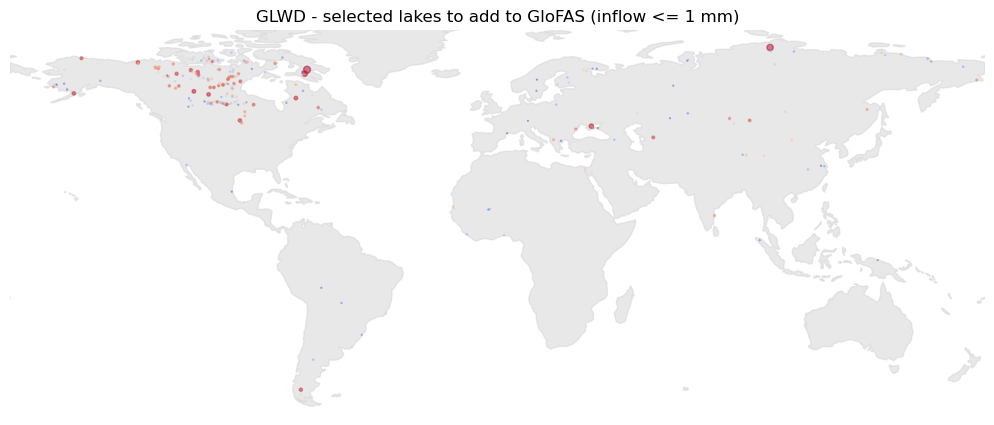

In [22]:
min_inflow = 1
glwd_mask_inflow = glwd_new.INFLOW_MM <= min_inflow
glwd_new_3 = glwd_new[glwd_mask_inflow]

fig, ax = plt.subplots(figsize=(20, 5), subplot_kw=dict(projection=ccrs.PlateCarree()))
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '110m', edgecolor='face', facecolor='lightgray'), alpha=.5, zorder=0)
glwd_new_3.plot(markersize=glwd_new_3.AREA_SKM * .5e-2, cmap='coolwarm_r', c=glwd_new_3.INFLOW_MM, alpha=.5, ax=ax, legend=True)#, color='firebrick'
ax.set_title('GLWD - selected lakes to add to GloFAS (inflow <= {0} mm)'.format(min_inflow))
ax.axis('off');

print('no. lakes:\t\t{0}'.format(glwd_new_3.shape[0]))
print('total lake area:\t{0:.0f} km²'.format(glwd_new_3.AREA_SKM.sum()))

<font color='red'>Filter out lakes that do not overlap GloFAS streams.</font>

## Global Reservoir and Dam (GRanD)

GRanD includes both a point shapefile of dams and a polygon shapefile with reservoirs. The amount of reservoirs is slightly smaller than that of dams, but the attributes are the same, so I will use only the dams for the analysis.

I have discovered that GloFAS considers as lakes some reservoirs in GRanD. I will try to list these cases, to exclude them from the list of new reservoirs to be included in GloFAS.

In [23]:
# import data set
path_GRanD = f'{path_datasets}reservoirs/GRanD/v1_3/'
grand = gpd.read_file(f'{path_GRanD}grand_dams_v1_3.shp')
grand.set_index('GRAND_ID', drop=True, inplace=True)
grand = grand.replace(-99, np.nan)

# convert in NaN suspicios values of degree of regulation
grand.DOR_PC = grand.DOR_PC.replace(10000, np.nan)

In [24]:
# fill in empty values in the GloFAS metadata using the GRanD data set
glofas['GRAND_ID'] = np.nan
for id in tqdm(glofas.index):
    if np.isnan(glofas.loc[id, 'GRAND_ID']):
        # extract info from GloFAS
        gf_lon, gf_lat = glofas.loc[id, ['LisfloodX3', 'LisfloodY3']]
        
        # compute "distance" from all points in GRanD
        diff = ((grand.LONG_DD - gf_lon)**2 + (grand.LAT_DD - gf_lat)**2)**.5
        if diff.min() <= 5 * glofas_pixel:
            grand_id = diff.idxmin()
            # grand_lake, grand_river = grand.loc[grand_id, ['RES_NAME', 'RIVER']]
            # if (gf_river == grand_river) | (gf_lake == grand_lake):
            #     glofas_.loc[id, ['GRAND_ID', 'LAKE_NAME', 'RIVER']] = grand_id, grand_lake, grand_river
            glofas.loc[id, 'GRAND_ID'] = grand_id
            # attributes = {'LAKE_NAME': 'RES_NAME', 'DAM_NAME': 'DAM_NAME', 'RIVER': 'RIVER'}
            # for gf_attr, grand_attr in attributes.items():
            #     if not isinstance(glofas.loc[id, gf_attr], str):
            #         glofas.loc[id, gf_attr] = grand.loc[grand_id, grand_attr]

  0%|          | 0/463 [00:00<?, ?it/s]

In [25]:
print('no. lakes for which a GRanD ID was found:\t{0}'.format(glofas[~glofas.GRAND_ID.isnull()].shape[0]))

no. lakes for which a GRanD ID was found:	63


After individual inspection, 42 of these lakes were found to actually overlap GRanD reservoirs:

In [26]:
# GLWD_ID of lakes overlaping GRanD reservoirs
glwd_id = [3, 8, 13, 15, 29, 38, 109, 130, 195, 261, 268, 340, 380, 393, 455, 555, 559, 613, 617, 707,
           722, 750, 761, 948, 961, 1002, 1064, 1095, 1182, 1204, 1285, 1368, 1423, 1448, 1519, 1537,
           1565, 1670, 1677, 1686, 1714, 2152]

In [27]:
grand_id = glofas.loc[glofas.GLWD_ID.isin(glwd_id), 'GRAND_ID'].astype(int).to_list()

## Lake Atlas

Interesting fields:

* `Lake_type` indicates the type of water body:
    * 1: lake.
    * 2: reservoir.
    * 3: lake control
* `Lake_area`: surface area in km².
* `Vol_total`: total lake/reservoir volume in km3.
* `Depth_avg`: average depth in m.
* `Dis_avg`: average long-term discharge (m3).
* `Res_time`: average residence time in days.
* `Wshd_area`: area of the lake's watershed in km2.
* `Pour_long` and `Pour_lat` are the coordinates of the pour point in decimal degrees.
* `dis_m3_pyr`: annual average natural discharge.

In [28]:
path_atlas_in = f'{path_datasets}lakes/HydroLAKES/LakeATLAS_v10_shp/'
path_atlas_out = '../data/lakes_wetlands/LakeATLAS/'

# columns to be used from HydroATLAS
cols = ['Hylak_id', 'Lake_name', 'Country', 'Continent', 'Poly_src', 'Lake_type', 'Grand_id', 'Lake_area',
        'Shore_len', 'Shore_dev', 'Vol_total', 'Vol_res', 'Vol_src', 'Depth_avg', 'Dis_avg',
        'Res_time', 'Elevation', 'Slope_100', 'Wshd_area', 'Pour_long', 'Pour_lat', 'dis_m3_pyr']

if 'atlas' in locals():
    del atlas
for file in tqdm(['LakeATLAS_v10_pnt_east.shp', 'LakeATLAS_v10_pnt_west.shp']):
    # load HydroLAKES
    ddf = dgpd.read_file(f'{path_atlas_in}{file}', columns=cols, npartitions=10)
    # remove reservoirs and small lakes
    mask_lakes = ddf.Lake_type == 1
    mask_area = ddf.Lake_area >= min_area
    ddf = ddf.loc[mask_lakes & mask_area]
    # compute and convert into geopandas
    df = ddf.compute()
    if 'atlas' not in locals():
        atlas = df
    else:
        atlas = pd.concat([atlas, df])
    del ddf, mask_lakes, mask_area, df
atlas = gpd.GeoDataFrame(atlas, geometry=[Point(xy) for xy in zip(atlas.Pour_long, atlas.Pour_lat)])

# exportar
atlas.to_file(f'{path_atlas_out}LakeATLAS_v10_pnt_filter.shp', driver='ESRI Shapefile', crs='EPSG:4326')

  0%|          | 0/2 [00:00<?, ?it/s]

In [37]:
min_area

50

In [29]:
atlas.columns

Index(['Continent', 'Country', 'Depth_avg', 'Dis_avg', 'Elevation', 'Grand_id',
       'Hylak_id', 'Lake_area', 'Lake_name', 'Lake_type', 'Poly_src',
       'Pour_lat', 'Pour_long', 'Res_time', 'Shore_dev', 'Shore_len',
       'Slope_100', 'Vol_res', 'Vol_src', 'Vol_total', 'Wshd_area',
       'dis_m3_pyr', 'geometry'],
      dtype='object')

In [33]:
glofas.columns

Index(['GLWD_ID', 'LAKE_NAME', 'COUNTRY', 'CONTINENT', 'LONG_DEG', 'LAT_DEG',
       'X_CORRECTE', 'Y_CORRECTE', 'X_coord_au', 'Y_coord_au', 'ZZ_note_lo',
       'GloFAS_sta', 'LisfloodX3', 'LisfloodY3', 'remap_com', 'avinflow', 'a',
       'A', 'geometry', 'GRAND_ID'],
      dtype='object')

In [38]:
atlas.Lake_area.sum()

1479761.2699999998

In [39]:
glofas.A.sum() / atlas.Lake_area.sum()

0.5104722061011909

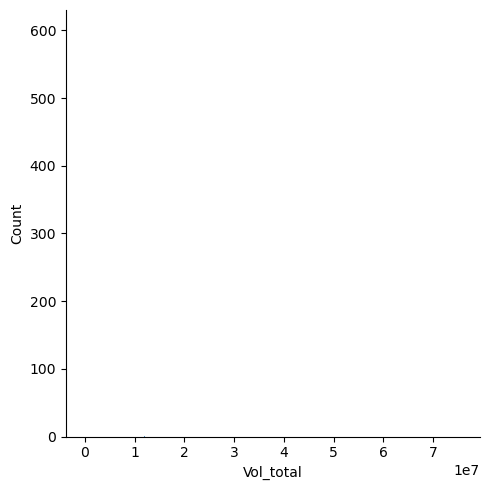

In [50]:
sns.displot(atlas.Vol_total)

In [43]:
atlas.Poly_src.value_counts()

SWBD      1139
CanVec    1130
MODIS      217
ECRINS      76
Other       75
NHD         54
GLWD        24
Name: Poly_src, dtype: int64

GloFAS includes 28% of the lake area in HydroLAKES. However, there are many unidentified reservoirs in HydroLAKES that are mistakingly considered lakes.

The smallest lake in the GloFAS dataset has an area of 50 km². I will analyse the lakes in the Lake Atlas over that minimum area to see if it's a manageble number of lakes and if they coincide with the GloFAS dataset.

In [ ]:
min_area = lakes_glofas.area.min()
print(f'The minimum lake area in GloFAS is {min_area} km²')
mask_area = atlas.Lake_area > min_area
atlas_area = atlas.loc[mask_area]
print('The Lake Atlas has {0} lakes with an area larger than {1} km²'.format(mask_area.sum(), min_area))
print('They account for {0:.1f}% of the total lake area in the Atlas dataset'.format(atlas_area.Lake_area.sum() / atlas.Lake_area.sum() * 100))

In [ ]:
atlas_area.sort_values('Lake_area', ascending=False).head(20)

In [ ]:
atlas_area.loc[atlas_area.Poly_src == 'GLWD']

In [ ]:
lakes_glofas.sort_values('area', ascending=False).head(20)

In [ ]:
atlas = atlas[cols]

In [ ]:
atlas.iloc[0][['Pour_long', 'Pour_lat', 'geometry']]

In [ ]:
atlas.columns.to_list()

In [ ]:
sns.displot(atlas.Lake_area)
plt.xlabel('area (km²)')
plt.ylabel('no. lakes')
plt.xscale('log');

In [ ]:
atlas.Lake_area.sum()

In [ ]:
lakes_glofas.area.min()

In [ ]:
atlas.Lake_area.describe()

In [ ]:
atlas.Lake_area.idxmax()

In [ ]:
atlas.Lake_area.iloc[0]